**Hanh Nong**
# <center>Analysis on Classic Experiments</center>

In [1]:
#setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sfa
from statsmodels.iolib.summary2 import summary_col
from scipy import stats

## Problem: 

Suppose we are considering deploying a new feature to increase time spent on a video platform. We run a small and short experiment to test its impact, with an equal treatment and control group.

The data following the experiment has four columns and 1200 rows. Each row corresponds to a separate user, for which there are four columns: time spent on platform (in seconds) during the experiment, an indicator for whether the user is in the treatment group (where 1 indicates treatment), the age of the user, and the number of channels (i.e. other accounts) to which the user previously subscribed.

In [2]:
#load data
data = pd.read_csv("data_assignment1.csv")
data.head()

,timespent,treatment,age,channels
0,228.565845,1,20,3
1,167.198848,1,27,0
2,142.921240,1,29,3
3,305.336382,1,13,6
4,170.465854,1,25,5


### Assessment of the experiment including both its estimated impact and the significance of that estimate, using both analytic techniques and the bootstrap.

Among different ages and number of channels, there is great fluctuation in effect. The control/treatment split is around 50% and this split is also consistent among each category of age and number of channels. In all age group, number of users who are 12 is much larger than all other age group. This probably is due to this age group is the main user segment of the platform.

Using t-test: 
- Null hypothesis: Mean of timespent of treatment group - Mean of timepspent of control group = 0
- Alternative hypothesis: Mean of timespent of treatment group - Mean of timepspent of control group > 0
- Significant level set at 5%

T-test returns the T score of 1.38 and p-value of 0.167 which is much higher than 5%. The estimated impact of the experiment is not statistically significant.

Overall, the estimated impact is an increase in time spent of 4.24 seconds when using the new color pallettes (see variable *te* in code below). This sounds like there is an effect of treatment.

In [58]:
#Calculate treatment effect:
te = data.query('treatment == 1')['timespent'].mean() - data.query('treatment == 0')['timespent'].mean()
print("Overall effect of the experiment:",round(te,2))

Overall effect of the experiment: 4.24


***T-test***

T-test is run in order to assess the significance of the result above. This t-test test whether there is significance difference between the means of two samples. With the significant set at 5%, the high value of p-value (0.1667) indicates this result is not statistically significant.

In [95]:
t, p = stats.ttest_ind(data.query('treatment ==1')['timespent'],data.query('treatment ==0')['timespent'])
print("t score:", round(t,3))
print("p-value:", round(p,3))

t score: 1.383
p-value: 0.167


***Bootstrap***

A simple bootstrap approach is used to assess the significance of the result. This approach assumes total randomness in the number of a particular age and channel value in each control and treatment group. This bootstrap preserve the exact number of units in each control and treatment groups.

In the original experiment, there are 600 control units and 600 treatment units. This could be understood in two ways:
- there are exactly 600 control units and 600 treatment units; or
- units are assigned into each group with the chance of 50% and there is no difference in total number of units in each group due to randomness.

For a population of 1,200 units, it is hard to ensure that there would be no random difference in number of units in each group. An intentional 600 control units and 600 treatment units is more believable. Moreover, by retaining this exact allocation, it would align with the t-test above for comparison purpose. Hence, this bootstrap goes with this exact allocation of control and treatment.

The following code is to run bootstrap:

In [46]:
mean_diff1 = []
reg_bstr_1 = []
regSimp_bstr_1 = []
regCmplx_bstr_1= []
n1_control = int(data.query('treatment == 0').shape[0])
n1_treatment = int(data.query('treatment == 1').shape[0])

for i in range(1000):
    
#BOOTSTRAP APPROACH 1: Number of units in each treatment and control groups is preserved.   
    index_control = np.random.choice(np.where(data['treatment']==1)[0], replace = True, size = n1_control)
    index_treatment = np.random.choice(np.where(data['treatment']==0)[0], replace = True, size = n1_treatment)
    sample1 = pd.concat([data.iloc[index_control], data.iloc[index_treatment]], ignore_index=True, sort=False)
    
    sample1['agesq'] = sample1['age']**2
    sample1['chansq'] = sample1['channels']**2
    sample1['dxchan'] = sample1['treatment']*sample1['channels']
    
    #non-regression bootstrap
    mean_diff1.append(sample1.query('treatment == 1')['timespent'].mean() -
                     sample1.query('treatment == 0')['timespent'].mean())
    
    #regression without covariate bootstrap   
    reg_bstr_1.append(sfa.ols("timespent ~ treatment", data=sample1)
                          .fit(cov_type='HC1')
                          .params[1])    
    
    #regression with simple covariates    
    regSimp_bstr_1.append(sfa.ols("timespent ~ treatment + age + channels", data=sample1)
                          .fit(cov_type='HC1')
                          .params[1]) 
    
    #regression with complex covariates
    regCmplx_bstr_1.append(sfa.ols("timespent ~ treatment + age + channels + agesq + chansq + dxchan", 
                                   data=sample1)
                           .fit(cov_type='HC1')
                           .params[1])

Result of bootstrap show an effect of 4.3 which aligns with the experiment. The standard error of 3 is very high for this value which indicates this effect is not significant. This conclusion is also consistent with t-test.

In [47]:
print("Mean of effect:",round(np.mean(mean_diff1),3))
print("std of mean difference:",round(np.std(mean_diff1), 3))

Mean of effect: 4.3
std of mean difference: 3.062


### Assess experiment using regression techniques but without using the additional covariates

***Regression: simple model***

In [49]:
reg = sfa.ols("timespent ~ treatment", data=data).fit(cov_type='HC1')
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:              timespent   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.914
Date:                Mon, 31 Aug 2020   Prob (F-statistic):              0.167
Time:                        17:58:01   Log-Likelihood:                -6469.1
No. Observations:                1200   AIC:                         1.294e+04
Df Residuals:                    1198   BIC:                         1.295e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    225.6296      2.126    106.118      0.0

The results in regression is quite similiar with what calculated in question 1: effect of 4.24 with standard error of 3 and p-value of 0.167. The $R^2$ is less than 1%. These results indicate the effect is not significant. This model is too simple to exlain the effect.

In [50]:
print("Coefficient of treatment:",round(reg.params[1],2))
print("Standard error of coefficient:",round(reg.bse[1],2))

Coefficient of treatment: 4.24
Standard error of coefficient: 3.07


***Bootstrap***

The same approach of bootstrap is used as before. Regression with the same formula for the simple model is run on bootstrap sample for each iteration. With this approach, there should be no difference in the results compared to above: Mean of effect is 4.3 and standard error of 3. With the standard error of 70% of the effect itself, this effect can't be significant

In [51]:
print("Mean of effect, simple model, bootstrap approach 1:",round(np.mean(reg_bstr_1),3))
print("std of simple model's coefficient, bootstrap approach 1:",round(np.std(reg_bstr_1), 3))

Mean of effect, simple model, bootstrap approach 1: 4.3
std of simple model's coefficient, bootstrap approach 1: 3.062


### Assess experiment using regression with additional covariates

Additional variables added are age and channels

In [35]:
regSimp = sfa.ols("timespent ~ treatment + age + channels", data=data).fit(cov_type='HC1')
print(regSimp.summary())

                            OLS Regression Results                            
Dep. Variable:              timespent   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     6156.
Date:                Mon, 31 Aug 2020   Prob (F-statistic):               0.00
Time:                        15:27:01   Log-Likelihood:                -4760.5
No. Observations:                1200   AIC:                             9529.
Df Residuals:                    1196   BIC:                             9549.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    412.4169      1.649    250.092      0.0

The effect of treatment has decreased to 3. P-value is very low and the standard error has decreased. $R^2$ increased 0.94. Including age and channels to the regression has significant impact to the model. Older ages lead to adverse impact to the effect. Channels also has a role in the time spent on the app. In this model, the effect of 3 is a significant result. This model does a better job in explaining the effect compared to the model in question 2. The result of 4.24 calculated in question 1 includes bias which was not shown in the initial regression.

### Assess experiment with more complex model

Some non-linear transformations of covariates (square of channels, square of age, and the interaction between channels and treatment) are added to the model

***Regression: Complex model***

In [38]:
data['agesq'] = data['age']**2
data['chansq'] = data['channels']**2
data['dxchan'] = data['treatment']*data['channels']

In [60]:
regCmplx = sfa.ols("timespent ~ treatment + age + channels + agesq + chansq + dxchan", data=data).fit(cov_type='HC1')
print(regCmplx.summary())

                            OLS Regression Results                            
Dep. Variable:              timespent   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     3157.
Date:                Mon, 31 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:12:54   Log-Likelihood:                -4750.1
No. Observations:                1200   AIC:                             9514.
Df Residuals:                    1193   BIC:                             9550.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    439.1900      6.313     69.574      0.0

***Bootstrap***

In [61]:
varSimp = np.var(regSimp_bstr_1)
varCmplx = np.var(regCmplx_bstr_1)
print("Variance of simple model:",round(varSimp,3))
print("Variance of complex model:",round(varCmplx,3))

Variance of simple model: 0.535
Variance of complex model: 1.833


From the results above, the complex model's variance is much higher than simple model. 

***Comparison of variances***

In below graph, by shifting parameter of complex model toward the simple model's mean, it's clearer to see how the complex model has higher variance than simple model.

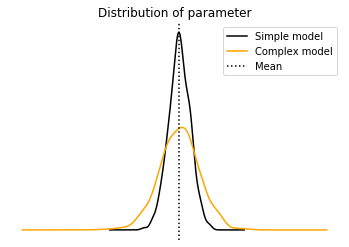

In [56]:
regCmplx_adj = regCmplx_bstr_1 + (np.mean(regSimp_bstr_1) - np.mean(regCmplx_bstr_1))
plot5 = pd.DataFrame({'Simple model': regSimp_bstr_1,'Complex model': regCmplx_adj})
plot5.plot.kde(color = ['black', 'orange'])
plt.title("Distribution of parameter")
plt.axvline(x=np.mean(regSimp_bstr_1),color='black', ls = ":", label = "Mean")
plt.axis('off')
plt.legend()

### Potential improvements to the simple model

- Summarize data by age and treatment (*data_by_age*); and by channel and treatment (*data_by_chan*). The summarized tables include count of units and difference in time spent for that specific group:

In [40]:
#Group data by age
data_by_age = data.groupby(['age','treatment'], as_index=False)[['timespent']].mean()
data_by_age = (data_by_age.join(data.groupby(['age','treatment'], as_index=False).size()
                                .reset_index(name = 'agecounts')['agecounts']))
data_by_age = data_by_age.pivot(index='age', columns='treatment', values=['timespent','agecounts']).reset_index()
data_by_age.columns = ['age','Y0','Y1','control','treatment']
data_by_age['effect'] = data_by_age['Y1']-data_by_age['Y0']

In [27]:
data_by_age

,age,Y0,Y1,control,treatment,effect
0,13,300.306872,306.435705,84.0,94.0,6.128833
1,14,283.654762,287.422619,32.0,32.0,3.767857
2,15,273.483640,276.950937,24.0,29.0,3.467297
3,16,268.112969,266.866166,30.0,30.0,-1.246803
4,17,258.715214,258.976891,34.0,34.0,0.261677
5,18,246.986568,251.238254,37.0,32.0,4.251686
6,19,238.225193,241.015767,31.0,37.0,2.790573
7,20,230.803126,233.612719,41.0,26.0,2.809593
8,21,220.568623,222.673286,27.0,32.0,2.104664
9,22,215.811048,214.603499,24.0,20.0,-1.207548


- Visualize the trend of effect by age and by channel; and the proportion of each age and channel in treatment and control group:

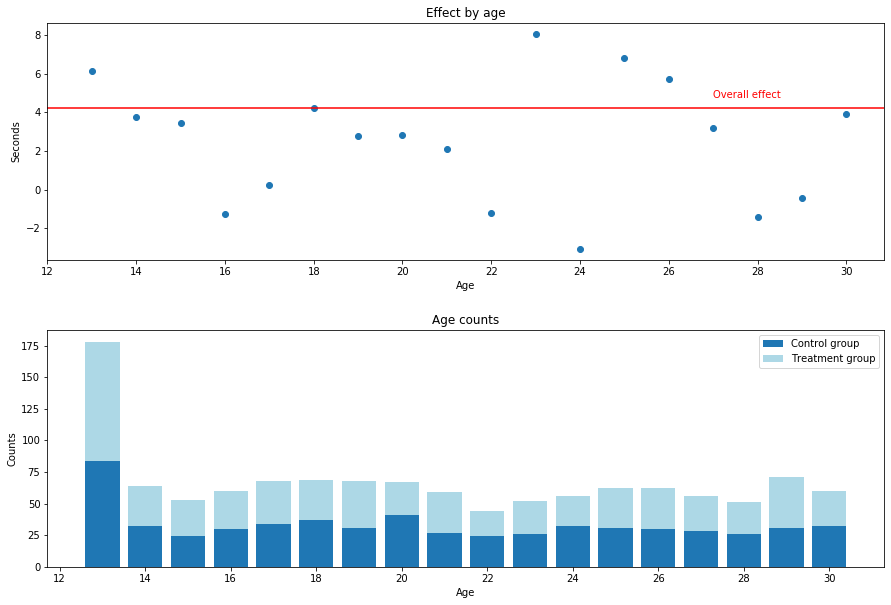

In [59]:
#Plot effect by age and by number of channels, distribution of age and number of channels in the sample
f, ax = plt.subplots(2,1,figsize=(15,10))
plt.subplots_adjust(hspace = 0.3)

#Effect by age
ax[0].scatter(data_by_age['age'],data_by_age['effect'])
ax[0].set_title('Effect by age')
ax[0].set(xlabel="Age",ylabel="Seconds")
ax[0].axhline(y=te,color='r')
ax[0].text(27,te+0.5,'Overall effect', color = 'r')
ax[0].set_xticks(np.arange(12, 31, step=2))

#Age counts
ax[1].bar(data_by_age['age'],data_by_age['control'], label = "Control group")
ax[1].bar(data_by_age['age'],data_by_age['treatment'], label = "Treatment group", 
             bottom=data_by_age['control'], color = 'lightblue')
ax[1].set_title('Age counts')
ax[1].set(xlabel="Age",ylabel="Counts")
ax[1].legend()
ax[1].set_xticks(np.arange(12, 31, step=2))

plt.show()

- Observation from the graph: 
    - Effect varies wildly between different age groups (See graph *Effect by age*). 
    - Except age 13, all other age groups are not very different in terms of total units in experiment. The proportion between treatment and control groups across all age groups is also quite consistent (See graph *Age counts*). 
    - The presence of age 13 in the population is much more noticeable than all other ages. Younger users might be more attracted a video platform. With or without the new feature, they already spent much more time on the app than other users. If this group has certain characteristics that are distinctly different from the rest, the effect of these characteristics will be projected on the overall effect.
    - In general, there is relatively gradual change in effect between age groups. However, from age 22-25, there are unusual leaps among these ages. There should not be such a dramatic change between these ages since they are very closed to each other. There could be noise in this subset of data. Or units in these age groups might have special characteristics. 
    
From the observation above, I would consider blocking age 13 and ages 23-25 from the rest.